## Predicting Vehicle Fuel Type for Households in California

11/2/2017

Provenance of the Data: California Housing Travel Survey

## Table of Contents

### [0. Imported Modules](#Imported-Modules)
### [1. Load Data](#Load-Data)
### [1.5. Join Data](#Join-Data)

### [2.0 Load from csv](#Load-From-CSV)
### [2. Predicting Vehicle Type](#Predicting-Vehicle-Type)
### [3. Transform and Preprocess Data](#Transform-and-Preprocess-Data)
### [4. Descriptive Statistics](#Descriptive-Statistics)
### [5. Build Preprocessed Dataset](#Build-Preprocessed-Dataset)
### [6. Feature Extraction](#Feature-Extraction)
### [7. Build Features](#Build-Features)
### [8. Baseline Models](#Baseline-Models)
### [9. Error Analysis](#Error-Analysis)
### [10. Change the Baseline](#Change-the-Baseline)
### [11. Decision Trees](#Decision-Trees)
### [12. Ensemble Methods](#Ensemble-Methods)
### [13. Summary](#Summary)

### Imported Modules
[Top](#Table-of-Contents)

In [215]:
# Tables, Queries, and Stats
import pandas as pd
import numpy as np

# Feature Selection
from sklearn.feature_selection import SelectKBest, chi2

# Pipeline
from sklearn.pipeline import Pipeline

# Plotting
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

# Data Partitioning
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

# Decision Tree Model and Plotting
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

# Ensemble Methods
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

# Error Analysis
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Computational Performance
import time

# OS, path, system access
import os
import os.path

### Load Data
[Top](#Table-of-Contents)

### There are 9 different Survey Tables in the CHTS

In [216]:
def get_tables_in(data_dir):
    print('Path to data on local machine: {}'.format(os.getcwd() + data_dir))
    tables_caltrans = [files for root, dirs, files in os.walk(os.getcwd() +\
                                                    data_dir, topdown=True, followlinks=False)][0]
    return tables_caltrans

In [122]:
#caltrans_tables = get_tables_in('/caltrans_full_survey/')
# Not all data fits in github, so download the data and load from outside the Repo:
caltrans_tables = get_tables_in('/../caltrans_full_survey/')

Path to data on local machine: /Users/vikram/cal/caltravel/../caltrans_full_survey/


In [123]:
def make_dfs_from_files(file_list, table_type, data_dir='../caltrans_full_survey/'):
    ''' Create Pandas DataFrames from the list of data files in CHTS. The 
    table_type signifies the group that the data belongs to.
    Possible groups: Surveys, Vehicles, Wearables
    
    Parms:
        file_list - all files in the survey
        table_type - survey, vehicle, wearable, or trip-level data
        data_dir - 
    Returns:
        
    '''
    start = time.time()
    subset_tables = {}
    if table_type == 'survey tables':
        subset = [file for file in file_list if file.startswith('survey_')]
    elif table_type == 'vehicle tables':
        subset = [file for file in file_list if file.startswith('v_')]
    elif table_type == 'wearable tables':
        subset = [file for file in file_list if file.startswith('w_')]
    elif table_type == 'trip-level tables':
        # Trip-level details are given via an OBD Engine sensor in each vehicle
        subset = [file for file in file_list if file.startswith('obd_')]
    else:
        print('Error: Please check name of table type.')
        return
    for file in subset:
        df = pd.read_csv(data_dir + file, low_memory=False)
        subset_tables[file] = df
    end = time.time()
    print('Loading the {} took {:.3f} seconds.'.format(table_type, end - start))
    return subset_tables

In [55]:
survey_tables = make_dfs_from_files(caltrans_tables, table_type='survey tables')
vehicle_tables = make_dfs_from_files(caltrans_tables, table_type='vehicle tables')
wearable_tables = make_dfs_from_files(caltrans_tables, table_type='wearable tables')
trip_level_tables = make_dfs_from_files(caltrans_tables, table_type='trip-level tables')

Loading the survey tables took 11.861 seconds.
Loading the vehicle tables took 1.531 seconds.
Loading the wearable tables took 15.630 seconds.
Loading the trip-level tables took 0.684 seconds.


### From the caltrans_data_dictionary, I know the following tables have veh_type defined:
 - survey_vehicles
 - v_obd_vehicles
 - gps_obd_vehicles

### Survey Tables, California Travel Housing Survey

### In the analysis below, I will use the following tables:
 - survey_households
 - survey_vehicles
 - survey_activity
 - survey_person
 - survey_place
 
We will add features from the other tables as we go.

In [56]:
list(survey_tables.keys())

['survey_activity.csv',
 'survey_households.csv',
 'survey_households_wgts.csv',
 'survey_longtrips.csv',
 'survey_longtrips_v02.csv',
 'survey_person.csv',
 'survey_person_wgts.csv',
 'survey_place.csv',
 'survey_vehicles.csv']

In [57]:
df_survey_households = survey_tables['survey_households.csv']
df_survey_vehicles = survey_tables['survey_vehicles.csv']
df_survey_activity = survey_tables['survey_activity.csv']
df_survey_person = survey_tables['survey_person.csv']
df_survey_place = survey_tables['survey_place.csv']

### Null Counts in the data

**Survey of Households**

In [58]:
def plot_nulls(dfs, titles):
    '''Plot nulls counts in list of data frames'''
    for df, title in zip(dfs, titles):
        pd.DataFrame(df.isnull().sum(), columns=['Null Count']).plot(kind='bar', figsize=(17,3),
                                                                    title='Null Counts in {} table'.format(title),
                                                                    );
# plot_nulls([df_survey_households, df_survey_vehicles, df_survey_activity, df_survey_person,
#            df_survey_place], titles=['households', 'vehicles','activity', 'person', 'place'])

### Join Data
[Top](#Table-of-Contents)

In [59]:
def left_join(left, right, how='left', on='sampno'):
    ''' Test for duplicates in the dfs and then join'''
    pass

def check_duplicates(df, on='sampno'):
    ''' 
    Checks if a Series has an duplicates to prepare for a join.
    Returns False if no duplicates. Otherwise it returns True and the number of duplicates
    '''
    duplicates = len(df[on].unique()) != len(df[on])
    if duplicates:
        num = len(df[on]) - len(df[on].unique())
        return duplicates, num
    else:
        return duplicates

In [60]:
# Testing if any duplicates in the tables

In [61]:
print(check_duplicates(df_survey_households), df_survey_households.shape)
print(check_duplicates(df_survey_vehicles), df_survey_vehicles.shape)
print(check_duplicates(df_survey_person, on='sampno'), df_survey_person.shape)
print(check_duplicates(df_survey_place), df_survey_place.shape)
print(check_duplicates(df_survey_activity), df_survey_activity.shape)

False (42426, 83)
(True, 39038) (79011, 38)
(True, 66682) (109113, 152)
(True, 418093) (460524, 54)
(True, 562280) (604711, 32)


Thus, there are 39,038 duplicate household entries out of the 79,011 entries for the survey_vehicles table. 

The duplicates in the vehicles table make sense because there could be more than 1 vehicle per household ('sampno').

Similarly, there is more than 1 place per household. In fact there are a lot of places per household:

df_survey_place.groupby('sampno').

**I will do a left join and keep the extra entries for now**

In [62]:
# Uncomment below to merge.
#df_place_activity = pd.merge(df_survey_activity, df_survey_place, on='sampno', how='left')

In [63]:
#df_place_activity.shape

### Exporting tables

In [64]:
#os.getcwd()

In [65]:
# This csv file is 4.5 GB on disk!!
#df_place_activity.to_csv(os.getcwd() + '/survey_place_activity.csv')

In [66]:
df_households_vehicles = pd.merge(df_survey_households, df_survey_vehicles, on='sampno', how='left')

In [67]:
#df_households_vehicles.to_csv(os.getcwd() + '/survey_households_vehicles.csv')

In [68]:
#df_house_veh_person = pd.merge(df_survey_person, df_households_vehicles, on='sampno', how='left')

In [69]:
#df_house_veh_person.to_csv(os.getcwd() + '/survey_households_vehicles_person.csv')

In [70]:
#print(df_households_vehicles.shape)
#print(df_house_veh_person.shape)

### Load From CSV
[Top](#Table-of-Contents)

In [218]:
df_households_vehicles = pd.read_csv(os.getcwd() + '/../survey_households_vehicles.csv', low_memory=False)

### Null values in the joined dataset

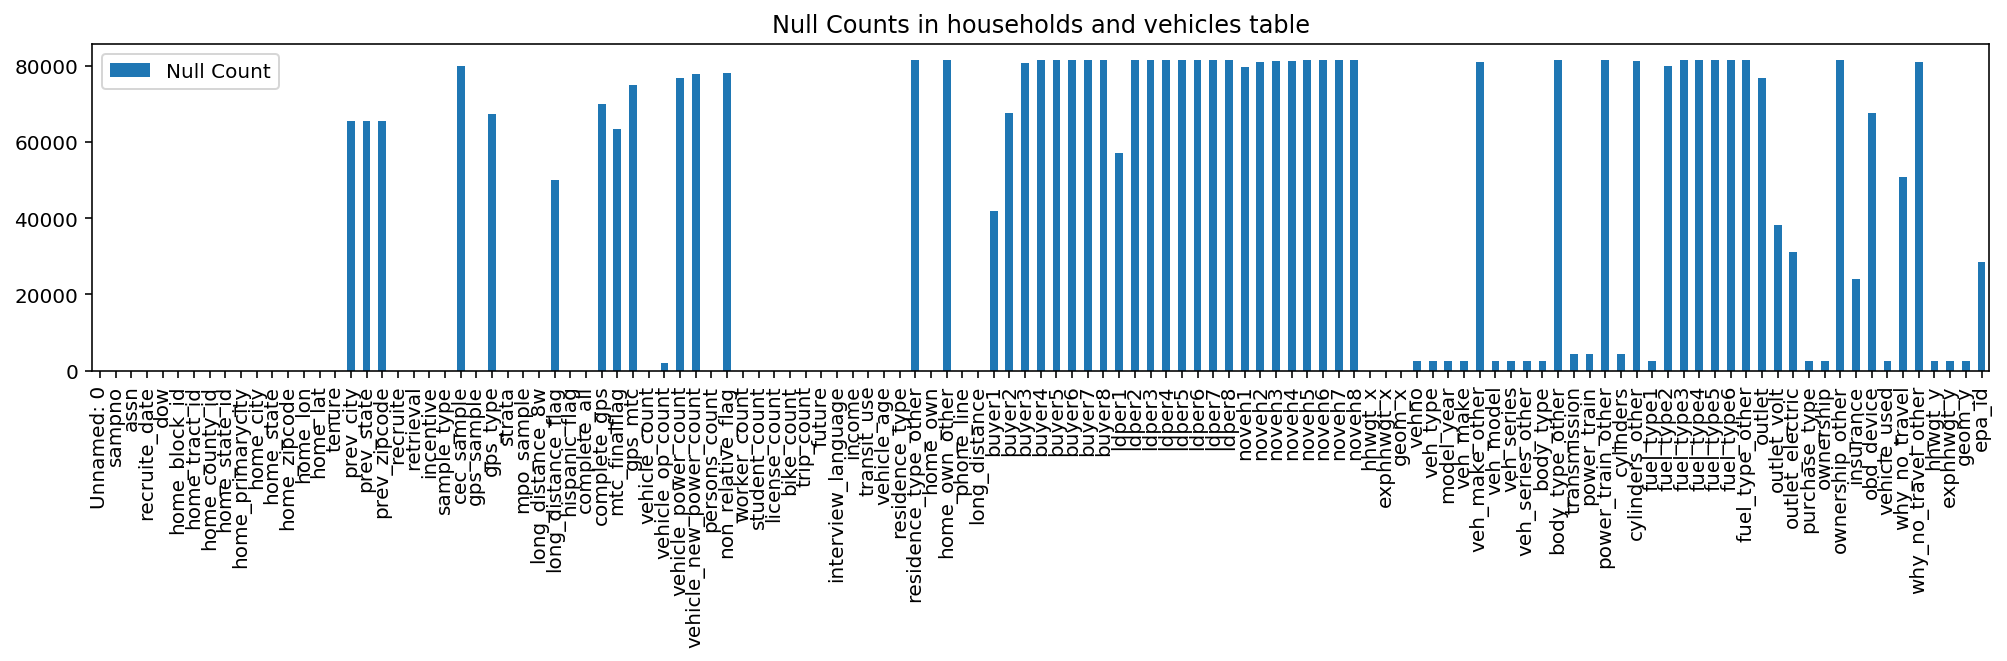

In [219]:
plot_nulls([df_households_vehicles], titles=['households and vehicles'])

### Predicting Vehicle Type
[Top](#Table-of-Contents)

**_ We want to predict vehicle type in order to find the relationship between demographic data and vehicle preference. Our demographic data includes: Education, gender, race, age, employment status, etc._**

# Transform and Preprocess Data
[Top](#Table-of-Contents)

Let's have a brief look at the data, see if there are any categorical variables, and transform them if so.

In [72]:
df_survey_hous_veh = df_households_vehicles.copy()

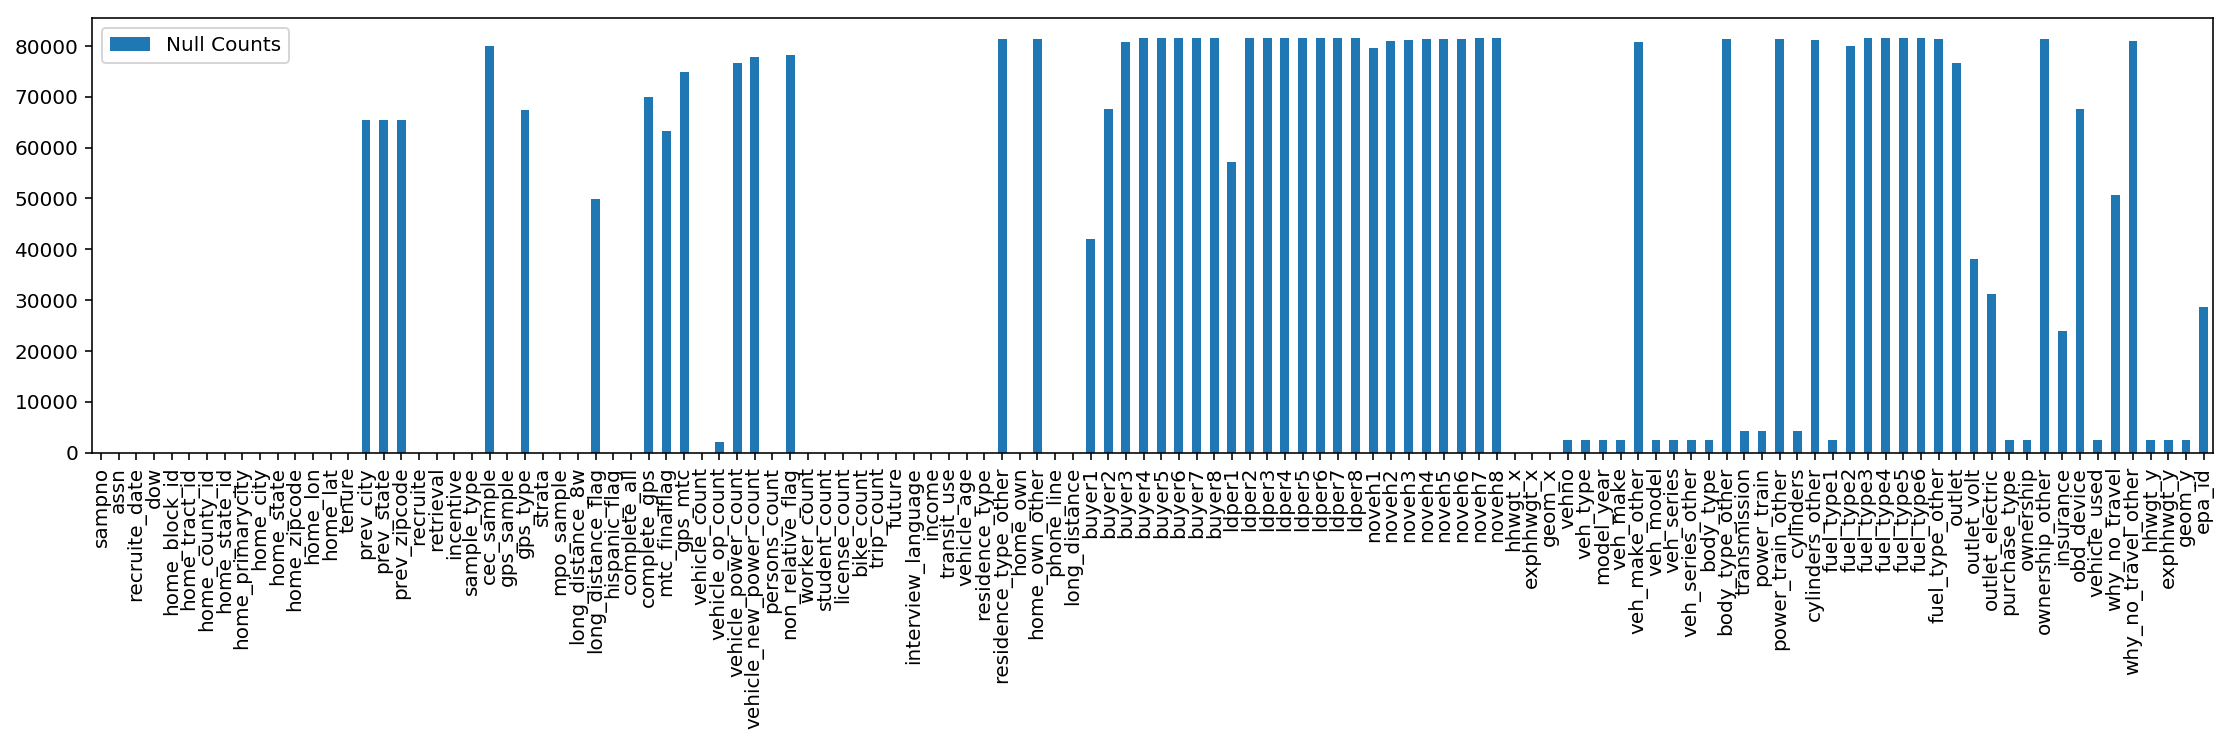

In [73]:
pd.DataFrame(df_survey_hous_veh.isnull().sum(), columns=['Null Counts']).plot(kind='bar', figsize=(19,4));

Based on the above graph, I will choose columns that don't have null values for now, and build a simple ML pipeline to predict veh_type.

In [220]:
def get_subset(df, column_names):
    ''' Return a subset of the dataframe based on the column names given.
    This will be used for quick prototyping of the entire pipeline.
    
    Parms:
        df - the original dataframe
        column_names - the column names to extract
    
    Returns:
        df_subset
    '''
    return df[column_names]

def nans_fill_zero(df):
    ''' One of many possible ways to handle any NaNs in the dataset.
    I will simply fill them with zeros.
    '''
    return df.fillna(0)

def get_bay_area(df):
    ''' 
    Get only the Bay Area housing instances 
    '''
    if 'home_county_id' not in df.columns:
        print('Error: no \'home_county_id\' column found')
        return
    else:
        df = df[df.home_county_id.isin([1, 13, 41, 55, 75, 81, 85, 95, 97])]
        return df

def remove_columns(df, name='persons_place'):
    '''
    Remove columns that may be irrelevant for a certain analysis.
    '''
    unnecessary_columns = ['recruite', 'incentive', 'sample_type', 'cec_sample', 'non_relative_flag',
                           'strata', 'mpo_sample', 'mtc_finalflag','buyer1', 'home_state_id',
                           'buyer2', 'buyer3', 'buyer4', 'buyer5', 'buyer6', 'buyer7', 'buyer8',
                           'ldper1', 'ldper2', 'ldper3', 'ldper4', 'ldper5', 'ldper6', 'ldper7',
                           'noveh3', 'noveh4', 'noveh5', 'noveh6', 'noveh7', 'noveh8', 'gps_mtc',
                           'ldper8', 'complete_all', 'complete_gps',
                           'sampno', 'hispanic_flag', 'assn', 'recruite_date', 'home_block_id',
                           'home_tract_id']
    if name=='persons_place':
        unnecessary_columns += ['hhwgt', 'exphhwgt', 'geom']
    if name=='housing_vehicle':
        unnecessary_columns += ['noveh1','noveh2','fuel_type3','fuel_type4','fuel_type5','fuel_type6']
    df = df.drop(unnecessary_columns, axis=1, inplace=False)
    #print(df.columns)
    #print(df.shape)
    return df

Notes, barriers: 
- Can't use home_lon or home_lat because they are 'REDACTED'.

#### Test Cases 
- Vehicle Type vs. Number of household workers and Number of household students

### Descriptive Statistics
[Top](#Table-of-Contents)

In [221]:
# Get Bay Area housing only
df_survey_hous_veh_ba = get_bay_area(df_survey_hous_veh)
df_survey_hous_veh_ba.shape

(18129, 120)

In [222]:
df_survey_hous_veh_ba = remove_columns(df_survey_hous_veh_ba,name='housing_vehicle')
df_survey_hous_veh_ba.shape

(18129, 74)

In [223]:
#get the types of all features in households dataset
df_survey_hous_veh_ba.head()
df_survey_hous_veh_ba.dtypes

#get the basic statistics of all features in households dataset
stats_survey_house_veh = pd.DataFrame({'mean': df_survey_hous_veh_ba.mean(), 'std': df_survey_hous_veh_ba.std(), \
                                      'min':df_survey_hous_veh_ba.min(), 'max':df_survey_hous_veh_ba.max()})
#trimmed_households.describe()
stats_survey_house_veh

,max,mean,min,std
bike_count,99,1.975840,0,3.542014
body_type,99,3.548094,1,7.495593
cylinders,99,17.248173,1,33.648750
dow,7,3.622869,1,1.703511
epa_id,37370,12828.417964,8,7202.126501
exphhwgt_x,1236.4,262.861553,8.4211,119.715667
exphhwgt_y,1236.4,259.199507,8.4211,117.496756
fuel_type1,9,1.053498,1,0.371608
fuel_type2,7,3.045369,1,0.817553
future,2,1.317392,1,0.465474


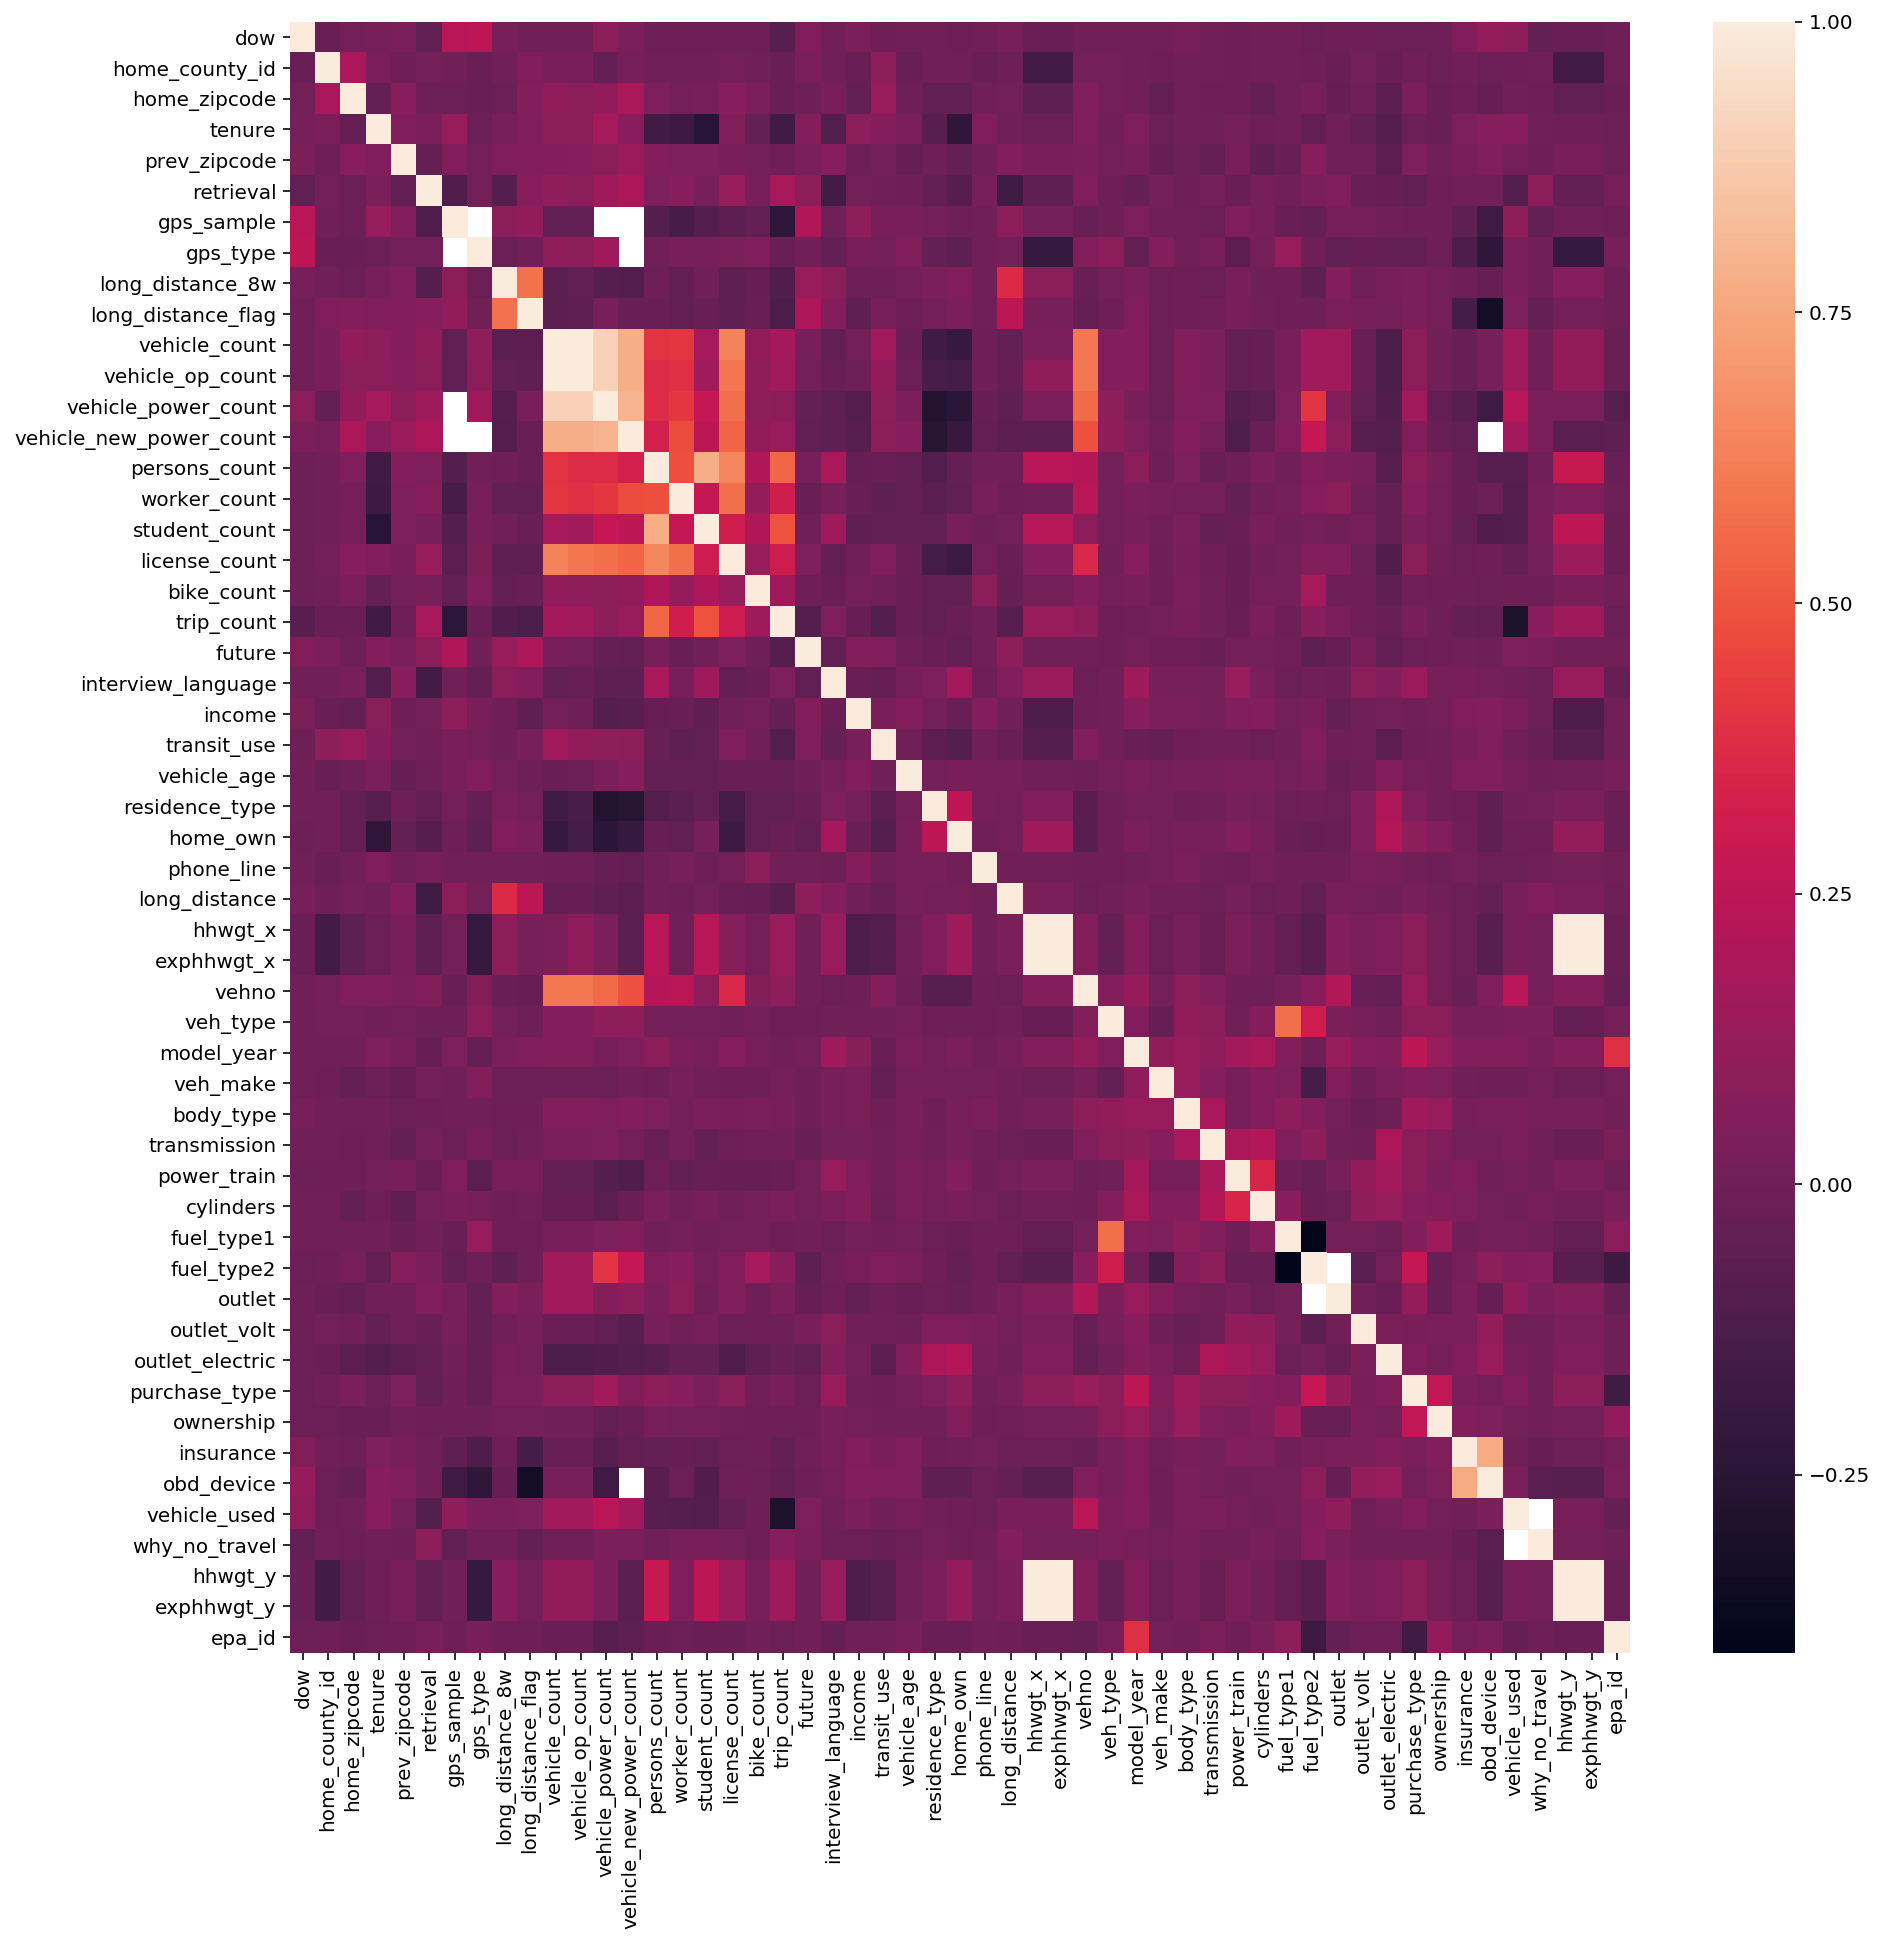

In [80]:
# correlation matrix of the trimmed household and vehicle set
fig, axes = plt.subplots(figsize=(15,15))
corrs = df_survey_hous_veh_ba.corr()
sns.heatmap(corrs, 
        xticklabels=corrs.columns,
        yticklabels=corrs.columns);

In [202]:
df_stats = df_survey_hous_veh_ba[['income', 'veh_type']].groupby('veh_type').count().reset_index()
df_stats[['veh_type', 'count']] = df_stats

In [203]:
df_stats = df_stats.drop(['income'],axis=1,inplace=False)

In [204]:
df_stats

,veh_type,count
0,1.0,1145
1,2.0,15799
2,3.0,342
3,4.0,42
4,5.0,20
5,6.0,94
6,7.0,54
7,9.0,1


In [205]:
df_stats_not_gas = df_stats.drop(1, axis=0, inplace=False)

Distribution of Non-Gas Cars


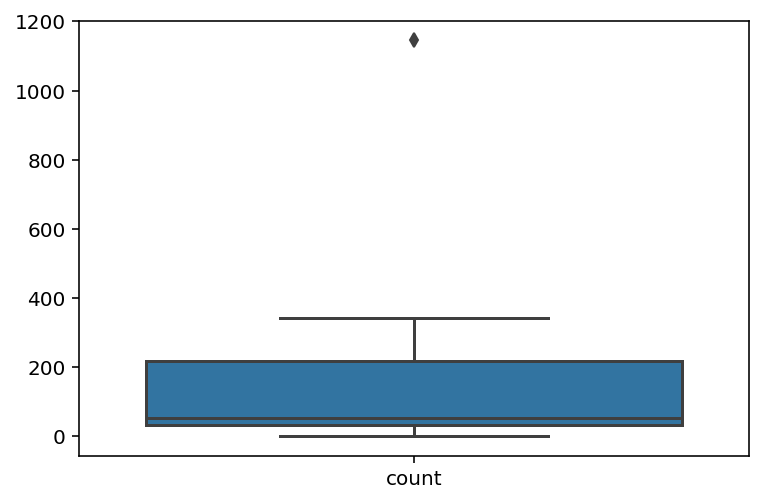

In [206]:
print('Distribution of Non-Gas Cars')
sns.boxplot(data=pd.DataFrame(df_stats_not_gas['count'], columns=['count']));

In [207]:
df_stats = df_survey_hous_veh_ba[['income', 'veh_type']].groupby('veh_type').mean().reset_index()
df_stats[['veh_type', 'mean_income']] = df_stats

In [208]:
# Add string column names
veh_type_num_to_name = {
    1:'Hybrid', 2: 'Gasoline-only', 3:'Diesel-only',
    4:'Plug-in Hybrid Electric', 5:'CNG', 6:'Electric Only',
    7:'Other',9:'DK/RF'
}
df_stats['name'] = df_stats['veh_type'].apply(lambda x: str(veh_type_num_to_name[int(x)]))

In [209]:
df_stats_income = df_stats.drop(['veh_type','income'], axis=1, inplace=False)

In [210]:
df_stats_income

,mean_income,name
0,17.369432,Hybrid
1,15.485094,Gasoline-only
2,17.441520,Diesel-only
3,16.857143,Plug-in Hybrid Electric
4,15.950000,CNG
5,16.563830,Electric Only
6,18.277778,Other
7,5.000000,DK/RF


In [211]:
def plot_income_vs_fuel_type(df_stats):
    fig, ax = plt.subplots(figsize=(8,5))
    ax.scatter(df_stats['veh_type'], df_stats['mean_income'])
    x = ['Hybrid','Gasoline-only','Diesel-only',
                        'Plug-in Hybrid Electric','CNG','Electric Only',
                        'Other','DK/RF']
    ax.set_xticks(list(range(1,len(x))) + [9])

    ax.set_xticklabels(x, rotation=45, ha='right')

    ax.set_ylabel('Average Income', fontsize=16, color='blue')
    ax.set_xlabel('Vehicle Fuel Type', fontsize=16, color='blue')

    ax.set_title('Average Household Income vs. Vehicle Fuel Type', fontsize=16, color='blue')
    ax.tick_params(labelsize=14, labelcolor='black')
    # Take out right and top axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

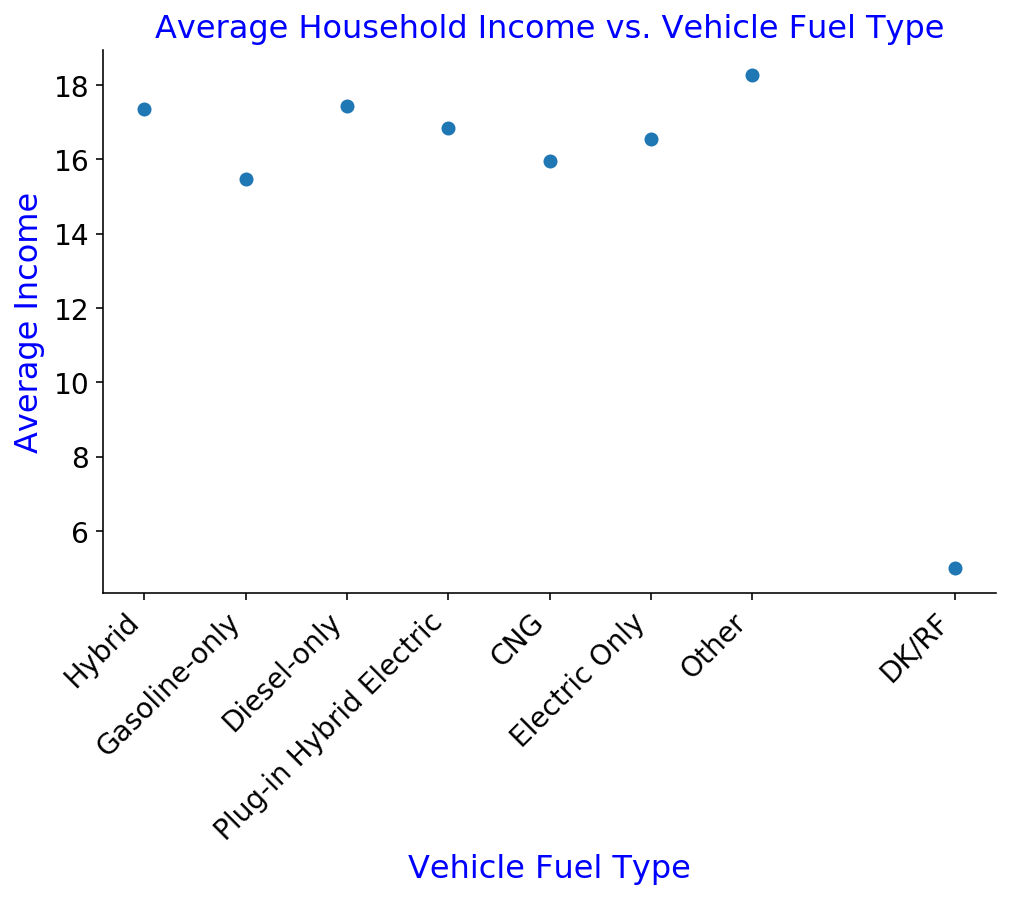

In [212]:
plot_income_vs_fuel_type(df_stats)

### Build Preprocessed Dataset
[Top](#Table-of-Contents)

In [224]:
def preprocess_data(df, column_subset=None):
    ''' Returns a preprocessed dataset. Possible preprocessing steps include:
     - getting a subset of the data
     - filling NaNs with zero, or some other value like the median of the data
     - scaling the data (z-score, etc.)
    
    Parms:
        df - the input data
        columns_subset - an optional subset of columns
    
    Returns:
        df_new - the output dataset
    '''
    df_new = df.copy()
    if column_subset:
        df_new = get_subset(df_new, column_subset)
    df_new = nans_fill_zero(df_new)
    return df_new

In [225]:
df_hous_veh_subset = preprocess_data(df_survey_hous_veh, 
                                     column_subset=['veh_type', 'worker_count', 'student_count'])

# Feature Extraction
[Top](#Table-of-Contents)

In [448]:
def expand_veh_type(df):
    ''' 
    Expanding the vehicle types into one-hot-vectors. Not really a feature, just helpful to read.
    '''
    df_new = df.copy()
    if 'veh_type' not in df.columns:
        print('Error: Vehicle type is not in the columns. Check if you dropped it already.')
        return
    
    # Create new columns based on discrete values
    veh_type_vecs = pd.get_dummies(df['veh_type'])
    
    # Add string column names
    veh_type_num_to_name = {
        0:'NaN', 1:'Hybrid', 2: 'Gasoline-only', 3:'Diesel-only',
        4:'Plug-in Hybrid Electric', 5:'CNG', 6:'Electric Only',
        7:'Other',9:'DK/RF'
    }
    column_names = [veh_type_num_to_name[num] for num in veh_type_vecs.columns]
    
    # Add these columns to the dataframe
    df_new[column_names] = veh_type_vecs
    
    # Drop the original columns
    df_new = df_new.drop('veh_type', axis=1, inplace=False)
    
    return df_new

def add_household_weight(df, df_full):
    df_new = df.copy()
    df_new['household_weight'] = df_full['hhwgt_y']
    return df_new

## Put more feature functions here...
def remove_string_columns(df, name='housing_vehicle'):
    '''
    Remove string columns that may be irrelevant for a certain analysis.
    Later dummy variablize these and add to regression.
    '''
    unnecessary_columns = []
    if name=='persons_place':
        unnecessary_columns += ['hhwgt', 'exphhwgt', 'geom']
    if name=='housing_vehicle':
        string_cols_remove = ['home_primarycity', 'prev_city','home_city', 
                              'prev_state', 'home_state', 'home_lon', 'home_lat',
                             'geom_x', 'geom_y', 'veh_make_other', 'veh_model',
                             'veh_series', 'why_no_travel', 'why_no_travel_other',
                             'fuel_type_other', 'ownership_other', 'cylinders_other',
                             'power_train_other', 'body_type_other', 'home_own_other',
                             'veh_series_other', 'residence_type_other'] 
            # removing types related to fuel                 
            #'fuel_type1', 'fuel_type2']
        unnecessary_columns += string_cols_remove
    df = df.drop(unnecessary_columns, axis=1, inplace=False)

    return df

### Build Features
[Top](#Table-of-Contents)

In [449]:
## Unused for now
def get_features(df, label):
    df_features = df.copy()
    df_features = df_features.drop(label, axis=1)
    return df_features
    
def get_labels(df, label):
    return pd.DataFrame(df[label])

def partition_data(features, labels):
    return train_test_split(features, labels, 
                           test_size=0.3,
                           random_state=789)
##

def build_features(df, df_full):
    ''' Build the final features dataframe
    
    Parms:
        df - the subsetted dataset
        df_full - the original dataset with all the columns
    Returns:
        df_features - the features dataframe
        df_target - the labels Series
    '''
    # Get and Store Labels
    df_target = df['veh_type'].copy().fillna(0)
    # Drop label from original df
    df = df.drop('veh_type', inplace=False, axis=1)
    
    # Get features from original dataset
    #df_features = add_household_weight(df, df_full)  
    df_features = nans_fill_zero(df)
    
    df_features = remove_string_columns(df_features)
    
    # add dummy variables for resulting category vars
    df_dummies = pd.get_dummies(df_features)
    #print(df_dummies.columns)
    df_features[df_dummies.columns] = df_dummies
    
    return df_features, df_target

In [450]:
df_features, df_target = build_features(df_survey_hous_veh_ba, df_survey_hous_veh)

In [451]:
train_features, test_features, train_labels, test_labels = train_test_split(df_features,
                                                                         df_target,
                                                                         test_size=0.3,
                                                                         random_state=789)

**Sanity check that there are no remaining null values**

In [452]:
#df_features.isnull().sum()
#df_features.sum()

In [453]:
#print([train_features[col] for col in train_features.columns])

### Baseline Models
[Top](#Table-of-Contents)

In [454]:
# all_features = get_features(df, 'put_label_name_here')
# all_labels = get_labels(df, 'put_label_name_here')
# train_features, test_features, train_labels, test_labels = partition_data(all_features, all_labels)
# train_labels = np.ravel(train_labels)
# test_labels = np.ravel(test_labels)

In [455]:
def train_and_test_model(model):
    print()
    print(model)
    print()
    print('Training model...')
    fitted = model.fit(train_features, train_labels)
    print('Test the model.')
    predicted = fitted.predict(test_features)
    predicted_classes = predicted.round()
    # My Model predicted all two's
    non_gas = [x for x in predicted_classes if x !=2]
    if len(non_gas) > 0:
        print('\nPredicted some non-gasoline cars.\n')
        ## Optionally uncomment below to print the non-gas predicted cars
        #print(non_gas)
    else:
        print('\nOnly gas cars predicted. Same as baseline prediction.\n')
    accuracy = accuracy_score(predicted_classes, test_labels)
    fscore = f1_score(predicted_classes, test_labels, average='weighted')
    print('This model\'s accuracy is {}'.format(accuracy))
    print('This model\'s f1 score is {}'.format(fscore))
    return predicted, accuracy

def get_predictions_and_scores(all_models):
    '''
    Store the predictions and scores in a list of tuples, that can be sorted based on a key. The key is the
    accuracy of each model.
    
    Returns the highest score and corresponding prediction of labels.
    '''
    predictions_and_accuracies = [train_and_test_model(model) for model in all_models]
    return max(predictions_and_accuracies, key=lambda x: x[1])

In [456]:
pipeline = Pipeline([('clf', DecisionTreeClassifier())])

In [457]:
len(train_features.columns)

51

In [431]:
all_models = [LinearRegression(), LogisticRegression(), BernoulliNB(), pipeline]
max_score_for_prediction = get_predictions_and_scores(all_models)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Training model...
Test the model.

Predicted some non-gasoline cars.

This model's accuracy is 0.9259054973340688
This model's f1 score is 0.9532350239846755

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Training model...


/Users/vikram/anaconda/envs/dsji/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/vikram/anaconda/envs/dsji/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Test the model.

Predicted some non-gasoline cars.

This model's accuracy is 0.9249862107004965
This model's f1 score is 0.9520807083014903

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

Training model...
Test the model.

Predicted some non-gasoline cars.

This model's accuracy is 0.8920757492186063
This model's f1 score is 0.8861131063202545

Pipeline(steps=[('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])

Training model...
Test the model.

Predicted some non-gasoline cars.

This model's accuracy is 0.9490715205000919
This model's f1 score is 0.9472991026655146


/Users/vikram/anaconda/envs/dsji/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/vikram/anaconda/envs/dsji/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [432]:
print('The best model has a score of {:.2f} percent.'.format(max_score_for_prediction[1]*100))

The best model has a score of 94.91 percent.


## Change the Baseline
[Top](#Table-of-Contents)

In [417]:
df_train_label = pd.DataFrame(train_labels, columns=['veh_type']).copy()

In [419]:
#df_dummy_veh_type.sum()

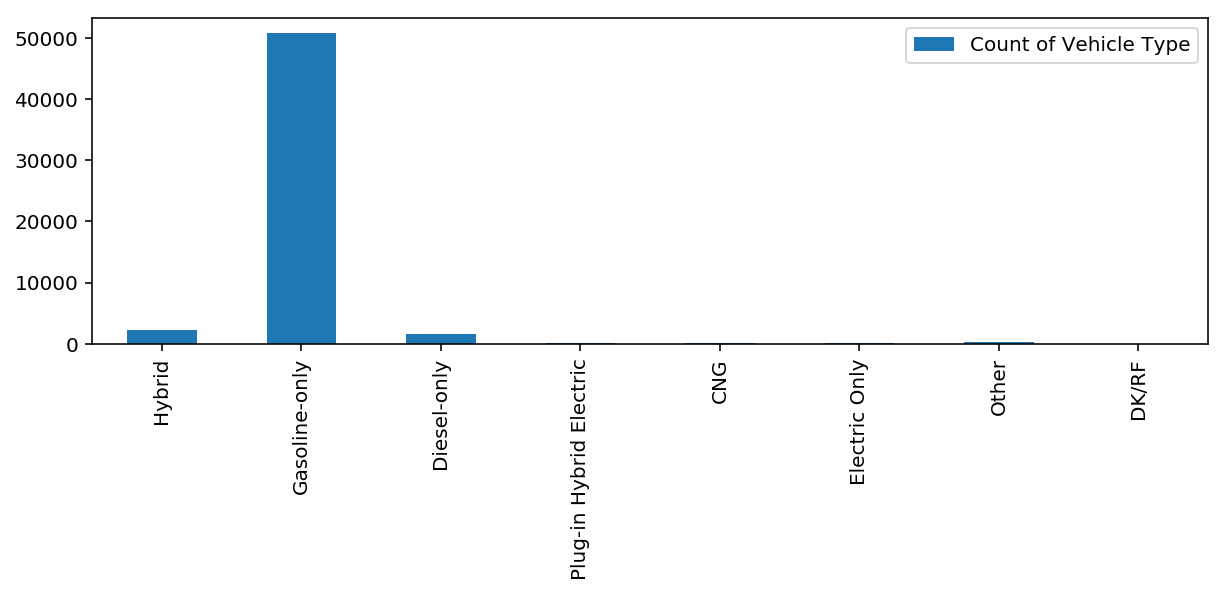

In [336]:
pd.DataFrame(df_dummy_veh_type.sum(), columns=['Count of Vehicle Type']).plot(kind='bar', figsize=(10,3));

**Predict all gasoline cars as the baseline.**

In [337]:
baseline_predictions = [2 for x in range(len(test_labels))]
print('Baseline Accuracy: {}'.format(accuracy_score(baseline_predictions, test_labels)))
print('Baseline F1-Score: {}'.format(f1_score(baseline_predictions, test_labels, average='weighted')))

Baseline Accuracy: 0.9197181910226122
Baseline F1-Score: 0.9581804197340952


/Users/vikram/anaconda/envs/dsji/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Error Analysis
[Top](#Table-of-Contents)

I will plot a confusion matrix to show how many false positives, false negatives, true positives, and true negative I classified using my model.

## Decision Trees
[Top](#Table-of-Contents)

In [458]:
def run_model(model):
    print()
    print('Training the model (Fitting to the training data) ')
    fitted = model.fit(train_features, train_labels)
    print('Fitted model: {}'.format(fitted))
    print('Test the model.')
    predicted = fitted.predict(test_features)
    predicted_classes = predicted.round()
    # My Model predicted all two's
    non_gas = [x for x in predicted_classes if x !=2]
    if len(non_gas) > 0:
        print('\nPredicted some non-gasoline cars. \n')
        #print(non_gas)
    else:
        print('\nOnly gas cars predicted. Same as baseline prediction.\n')
    accuracy = accuracy_score(predicted_classes, test_labels)
    fscore = f1_score(predicted_classes, test_labels, average='weighted')
    print('This model\'s accuracy is {}'.format(accuracy))
    print('This model\'s f1 score is {}'.format(fscore))
    return fitted

def decision_tree(leaf_nodes=10):
    return run_model(DecisionTreeClassifier(max_leaf_nodes=leaf_nodes))

In [459]:
dt_classifier = decision_tree()


Training the model (Fitting to the training data) 
Fitted model: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=10, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Test the model.

Predicted some non-gasoline cars. 

This model's accuracy is 0.9628608200036771
This model's f1 score is 0.9697663691456816


/Users/vikram/anaconda/envs/dsji/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [460]:
feature_names = df_features.columns
label_names = pd.DataFrame(df_target, columns=['veh_type']).columns
dot_data = export_graphviz(dt_classifier, out_file=None,
               feature_names=feature_names,
               # Below are the Vehicle Type classes
               class_names=['Hybrid','Gas-Only','Diesel-Only','Plug-in Hybrid','CNG',
                            'Electric-Only','Other','DK/RF'],
               filled=True, rounded=True,
               special_characters=False)
graph = pydotplus.graph_from_dot_data(dot_data)

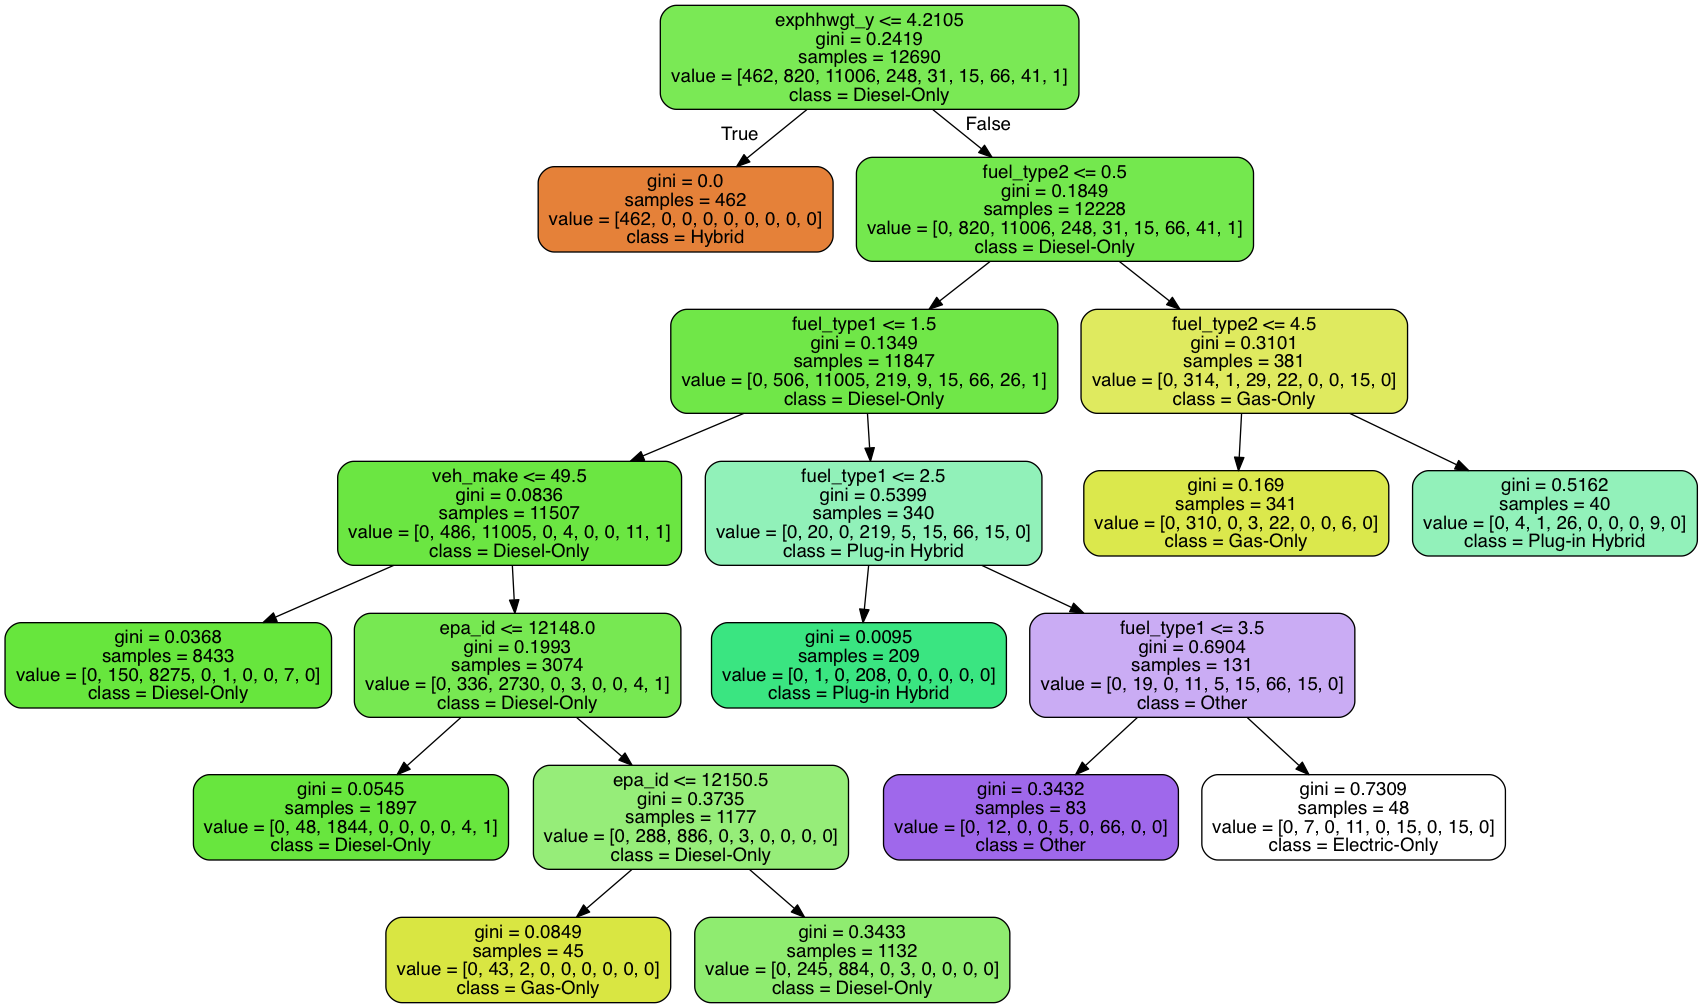

In [461]:
Image(graph.create_png())

In [463]:
train_features.columns

Index(['dow', 'home_county_id', 'home_zipcode', 'tenure', 'prev_zipcode',
       'retrieval', 'gps_sample', 'gps_type', 'long_distance_8w',
       'long_distance_flag', 'vehicle_count', 'vehicle_op_count',
       'vehicle_power_count', 'vehicle_new_power_count', 'persons_count',
       'worker_count', 'student_count', 'license_count', 'bike_count',
       'trip_count', 'future', 'interview_language', 'income', 'transit_use',
       'vehicle_age', 'residence_type', 'home_own', 'phone_line',
       'long_distance', 'hhwgt_x', 'exphhwgt_x', 'vehno', 'model_year',
       'veh_make', 'body_type', 'transmission', 'power_train', 'cylinders',
       'fuel_type1', 'fuel_type2', 'outlet', 'outlet_volt', 'outlet_electric',
       'purchase_type', 'ownership', 'insurance', 'obd_device', 'vehicle_used',
       'hhwgt_y', 'exphhwgt_y', 'epa_id'],
      dtype='object')

**Random Forest**

In [462]:
run_model(RandomForestClassifier(
    n_estimators=100, max_leaf_nodes=20)
    );


Training the model (Fitting to the training data) 
Fitted model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=20,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Test the model.

Predicted some non-gasoline cars. 

This model's accuracy is 0.939327082184225
This model's f1 score is 0.9557091841745792


/Users/vikram/anaconda/envs/dsji/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Summary
[Top](#Table-of-Contents)